In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/assistments2009train.csv')

df.head(), df.shape

df.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].sort_values()[-100:]
n_user = df['user'].nunique()

In [2]:
coef = np.load('coef0-2009train.npy')
theta, e = coef[0, :-124], coef[0, -124:]

In [3]:
n_skills = df['skill'].nunique()
n_items = df['item'].nunique()
df["skill_id"] = df["skill"].astype('category')
df["skill_id"] = df["skill_id"].cat.codes
df["item_id"] = df["item"].astype('category')
df["item_id"] = df["item_id"].cat.codes
items_per_skill = df.groupby('skill_id')['item'].nunique()

seq = [
    (
        theta[user_id],
        [tuple(x) for x in user[['item_id', 'skill_id', 'correct']].to_numpy()]
    )
    for user_id, user in df.groupby('user')
]

In [4]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def irt(theta, e):
    return sigmoid(theta + e)

In [51]:
import torch
from models import RNN

import numpy as np

seq_size=100

device = torch.device('cpu')

hidden_dim, n_layers = 200, 2
rnn = RNN(n_skills, n_items, items_per_skill, hidden_dim=[hidden_dim, 20], n_layers=[n_layers, 1],
          embed_size=32, n_epochs=450, lr=0.01, device=device)

# ls = rnn.fit(X, Y)
#torch.save(rnn.state_dict(), f'{seq_size}-{hidden_dim}-{n_layers}.pt')
#rnn = RNN(*args, **kwargs)
rnn.load_state_dict(torch.load(f'2009train-{seq_size}-{hidden_dim}-{n_layers}.pt', map_location=device))
rnn.eval()

RNN(
  (embed): Embedding(225, 32)
  (rnn): GRU(32, 201, num_layers=2, batch_first=True)
  (oh_skill): Linear(in_features=201, out_features=225, bias=True)
)

In [52]:
%%time

from scipy.stats import norm
from tqdm import tqdm

N = len(seq)
lens = []
S = []
gen_theta = norm(theta.mean(), theta.std()).rvs(N)

for i in tqdm(range(N)):
    s = rnn.gen(theta=gen_theta[i], e=e[sorted(df['skill'].unique())], max_n=1000)
    S.append(s)
    # print(len(s), s[:10])
    lens.append(len(s))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2081/2081 [01:53<00:00, 18.37it/s]

CPU times: user 10min 32s, sys: 1.64 s, total: 10min 34s
Wall time: 1min 53s


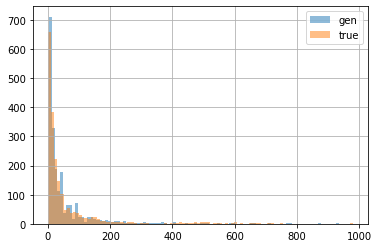

In [55]:
import matplotlib.pyplot as plt

plt.hist(lens, bins=100, alpha=0.5, label='gen')
df.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].hist(bins=100, alpha=0.5, label='true')
plt.legend()

<AxesSubplot:>

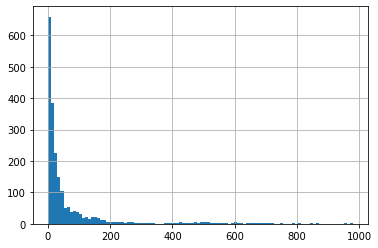

In [8]:
df.groupby('user').size().reset_index().rename(columns={0: 'count'})['count'].hist(bins=100)

In [56]:
sum(len(s) for s in S), len(df)

(127191, 140185)

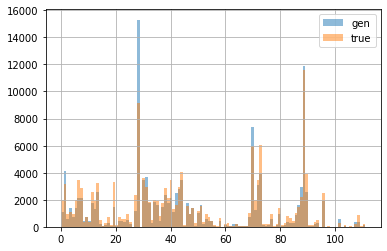

In [58]:
plt.hist([skill for s in S for skill, _, _ in s if skill != -1], bins=112, alpha=0.5, label='gen')
df['skill_id'].hist(bins=112, alpha=0.5, label='true')
plt.legend()

<AxesSubplot:>

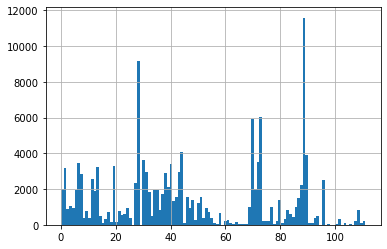

In [11]:
df['skill_id'].hist(bins=112)

In [46]:
def pplist(l, s=2):
    s = True
    for x in l:
        if x < 0:
            break
        if s:
            s = False
            print('[', end='')
        else:
            print(', ', end='')
        print(f'{x:2}', end='')
    print(']')

In [59]:
for s in S[:10]:
    pplist([skill for skill, _, _ in s[:20]])

[ 9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9, 10,  9,  7]
[30, 30, 30, 31]
[71, 73, 34, 34, 34, 34, 28, 72, 72, 51, 51, 51, 51, 42, 42, 42, 42, 42, 43, 43]
[ 9]
[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 44,  6]
[ 1,  1,  1,  1,  1,  1,  1, 10,  7,  7,  7, 60, 60,  4,  4,  4,  4]
[ 6,  6,  6,  6, 13, 13]
[44]
[34, 40, 34, 40, 34, 70, 70, 70, 70, 70, 70, 70, 70, 72, 72, 88, 70, 70, 70, 70]
[39, 39, 39, 39, 39, 46]


In [14]:
for _, s in seq[:10]:
    pplist([skill for _, skill, _ in s[:20]])

[71, 73, 73, 71, 34, 72, 38, 70, 70, 72, 72, 33,  6,  6,  6,  6, 34, 40, 71, 73]
[11, 71, 73, 72, 73, 73, 73, 73, 38, 71, 71, 71, 71, 34, 70, 72, 72, 70, 70, 33]
[71, 73, 72, 73, 71, 38, 34, 70, 72, 72, 70, 70, 33, 16, 72, 40, 34, 71, 73, 73]
[ 6,  6,  7,  7,  7,  7,  7, 71, 71, 71, 71, 71, 73, 73, 73, 73, 73, 72, 73, 38]
[71, 73, 72, 73, 38, 38, 38, 38, 38, 71, 34, 70, 70, 70, 70, 70, 72, 72, 70, 70]
[ 0,  0,  0,  0,  0,  2,  2, 47, 47, 47, 47, 47, 42, 38, 38, 38, 38, 38, 28, 28]
[33, 71, 73, 72, 73, 38, 38, 71, 34, 70, 72, 72, 70, 70, 16, 72, 38, 38, 38, 72]
[71, 71, 71, 71, 71, 73, 72, 73, 38, 71, 34, 34, 34, 34, 71, 71, 70, 72, 72, 70]
[ 6, 71, 73, 73, 73, 73, 73, 72, 38, 71, 34, 70, 72, 72, 70, 70, 33, 16, 72, 40]
[71, 73, 72, 73, 38, 38, 38, 38, 38, 71, 34, 70, 72, 72, 72, 72, 72, 34, 34, 71]


In [36]:
np.argmin([len(s) for _, s in seq])

199

In [60]:
S[0][:10]

[(9, 0, -0.1413507006289494),
 (10, 1, -0.1413507006289494),
 (9, 0, -0.1413507006289494),
 (10, 0, -0.1413507006289494),
 (9, 0, -0.1413507006289494),
 (10, 0, -0.1413507006289494),
 (9, 0, -0.1413507006289494),
 (10, 0, -0.1413507006289494),
 (9, 0, -0.1413507006289494),
 (10, 0, -0.1413507006289494)]

In [62]:
skills = sorted(df['skill'].unique())

In [61]:
sum(len(s) for s in S)

127191

In [63]:
with open('gen_skills.csv', 'w') as f:
    print('user,skill_id,skill,correct,theta', file=f)
    for i, s in enumerate(S):
        for skill_id, correct, theta in s[:-1]:
            skill = skills[skill_id]
            print(f'{i},{skill_id},{skill},{correct},{theta:.6}', file=f)

# Assistments 2012

In [18]:
df12 = pd.read_csv('data/assistments2012.csv')

In [19]:
df12.head()

,user_id,item_id,timestamp,correct,inter_id,skill_id
0,4355,27076,0,0,0,191
1,3825,23707,85,1,1,64
2,3825,23680,103,0,2,64
3,4355,26976,122,1,3,191
4,3825,23625,190,0,4,64


In [20]:
df12['skill_id'].max()

264

In [21]:
df12['item_id'].nunique(), df12['user_id'].nunique(), df12['skill_id'].nunique()

(52976, 24750, 265)